In [0]:
import os
import sys
import time
import glob
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from imgaug import augmenters as iaa
from sklearn.model_selection import train_test_split
import warnings
import random
from skimage.measure import find_contours
from sklearn import preprocessing
from matplotlib import patches
import webbrowser
from google.colab import drive
from google.colab.patches import cv2_imshow

## Mounts Google Drive if it's not mounted yet
if not os.path.isdir('/content/drive'):
  drive.mount('/content/drive')

In [0]:
# Root directory of the project
ROOT_DIR = "/content/drive/My Drive/Computer_Vision/MaskPCB/"

# Path to libraries
LIB_PATH = os.path.join(ROOT_DIR, 'libs/')
sys.path.append(LIB_PATH)

# Path for DeepPCB dataset
PCB_DATASET = "/content/drive/My Drive/Computer_Vision/MaskPCB/Dataset/"

# Directory to predictions
PCB_OUTPUTS = os.path.join(ROOT_DIR, "Predictions/")
if not os.path.exists(PCB_OUTPUTS):
    os.mkdir(PCB_OUTPUTS)

In [3]:
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

Using TensorFlow backend.


In [0]:
def parse_data(dataframe):

        # Creates a empty dictionary with image names as entry keys
    annotations = {os.path.join(PCB_DATASET, 'images', name): [] for name in dataframe['image']}
    image_paths = []

    # Each row of dataframe contains two columns: images and annotations, the former
    # is image file name and later is the file name of a .txt containing the respective
    # labels of that image
    for _, rows in dataframe.iterrows():

        # Appends the folder location of image
        image_paths.append(os.path.join(PCB_DATASET, 'images', rows['image']))

        # The image labels are spatial localization (Bounding boxes) of the PCB defects and its
        # respective class (open, short, mousebite, spur, copper or pin-hole). Each line of
        # annotation file is given in the format x1,y1,x2,y2,type, where (x1, y1) and (x2, y2)
        # are top left corner and bottom right corner of the bounding box.
        with open(os.path.join(PCB_DATASET, 'annotations', rows['annotations']), 'r') as f:
            line = f.read().replace(' ', ',').splitlines()
        line = [[s for s in string.split(',')] for string in line]
        annotations[os.path.join(PCB_DATASET, 'images', rows['image'])] = line

    return image_paths, annotations

def get_latest_model(model, config):

    dir_names = next(os.walk(model.model_dir))[1]
    key = config.NAME.lower()
    dir_names = filter(lambda f: f.startswith(key), dir_names)
    dir_names = sorted(dir_names)

    if not dir_names:
        import errno
        raise FileNotFoundError(
            errno.ENOENT,
            "Could not find model directory under {}".format(self.model_dir))

    fps = []
    # Pick last directory
    for d in dir_names:
        dir_name = os.path.join(model.model_dir, d)
        # Find the last checkpoint
        checkpoints = next(os.walk(dir_name))[2]
        checkpoints = filter(lambda f: f.startswith("mask_rcnn"), checkpoints)
        checkpoints = sorted(checkpoints)
        if not checkpoints:
            print('No weight files in {}'.format(dir_name))
        else:
            checkpoint = os.path.join(dir_name, checkpoints[-1])
            fps.append(checkpoint)

    model_path = sorted(fps)[-1]
    print('Found model {}'.format(model_path))

    return model_path

def get_train_data(dataframe, ORIG_SIZE, val_size=0.2):

    # get data from dataframe
    image_paths, annotations = parse_data(dataframe)

    # Split into training e validation sets
    X_train, X_val = train_test_split(image_paths, test_size=val_size, random_state=42)

    dataset_train = PCBDataset(X_train, annotations, ORIG_SIZE, ORIG_SIZE)
    dataset_train.prepare()

    dataset_val = PCBDataset(X_val, annotations, ORIG_SIZE, ORIG_SIZE)
    dataset_val.prepare()

    return dataset_train, dataset_val


def get_test_data(dataframe, ORIG_SIZE):

    # get data from dataframe
    image_paths, annotations = parse_data(dataframe)

    dataset = PCBDataset(image_paths, annotations, ORIG_SIZE, ORIG_SIZE)
    dataset.prepare()

    return dataset

In [0]:
def get_colors_for_class_ids(class_ids):

    # Define a different color for each defect class
    # 1-open, 2-short, 3-mousebite, 4-spur, 5-copper, 6-pin-hole
    COLORS = {1: (.941, .204, .204),
              2: (.204, .941, .941),
              3: (.204, .941, .204),
              4: (.204, .204, .941),
              5: (1., .498, .314),
              6: (.500, .300, .750)}
    
    colors = []
    for class_id in class_ids:
        if class_id in COLORS:
            colors.append(COLORS[class_id])

    return colors

def visualize_predictions(test_image, image_id, classes, save=True, display=True):

    # Load configurations for inference
    inference_config = InferenceConfig()

    # Recreate the model in inference mode
    model = modellib.MaskRCNN(mode='inference',
                              config=inference_config,
                              model_dir=ROOT_DIR)

    model_path = get_latest_model(model, inference_config)

    # Load trained weights (fill in path to trained weights here)
    assert model_path != "", "Provide path to trained weights"
    print("Loading weights from ", model_path)
    model.load_weights(model_path, by_name=True)

    fig = plt.figure(figsize=(10, 30))
    plt.subplot(1, 1, 1)
        
    results = model.detect([test_image], verbose=1)
    r = results[0]
    display_instances(test_image, r['rois'], r['masks'], r['class_ids'],
                        classes, r['scores'],
                        colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1], title='predicted', text_color=(.6, .6, 0))
    if save:
        plt.savefig(os.path.join(PCB_OUTPUTS, f"pred_{image_id}.png"), bbox_inches="tight")
        # plt.close('all')

    if display:
        plt.show()
    else:
        plt.close('all')

def display_instances(image, boxes, masks, class_ids, class_names,
                      scores=None, title="",
                      figsize=(16, 16), ax=None,
                      show_mask=True, show_bbox=True,
                      colors=None, captions=None, text_color=None):
    """
    boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    masks: [height, width, num_instances]
    class_ids: [num_instances]
    class_names: list of class names of the dataset
    scores: (optional) confidence scores for each box
    title: (optional) Figure title
    show_mask, show_bbox: To show masks and bounding boxes or not
    figsize: (optional) the size of the image
    colors: (optional) An array or colors to use with each object
    captions: (optional) A list of strings to use as captions for each object
    """
    # Number of instances

    def apply_mask(image, mask, color, alpha=0.5):
        """Apply the given mask to the image.
        """
        for c in range(3):
            image[:, :, c] = np.where(mask == 1,
                                      image[:, :, c] *
                                      (1 - alpha) + alpha * color[c] * 255,
                                      image[:, :, c])
        return image

    N = boxes.shape[0]
    if not N:
        print("\n*** No instances to display *** \n")
    else:
        assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

    # If no axis is passed, create one and automatically call show()
    auto_show = False
    if not ax:
        _, ax = plt.subplots(1, figsize=figsize)
        auto_show = True

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.set_title(title)

    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        color = colors[i]

        # Bounding box
        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue
        y1, x1, y2, x2 = boxes[i]
        if show_bbox:
            p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                                  alpha=0.7, linestyle="dashed",
                                  edgecolor=color, facecolor='none')
            ax.add_patch(p)

        # Label
        if not captions:
            class_id = class_ids[i]
            score = scores[i] if scores is not None else None
            label = class_names[class_id]
            caption = "{} {:.3f}".format(label, score) if score else label
        else:
            caption = captions[i]
        ax.text(x1, y1 + 8, caption,
                color=text_color, size=11, backgroundcolor="none")

        # Mask
        mask = masks[:, :, i]
        if show_mask:
            masked_image = apply_mask(masked_image, mask, color)

        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        padded_mask = np.zeros(
            (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = find_contours(padded_mask, 0.5)
        for verts in contours:
            # Subtract the padding and flip (y, x) to (x, y)
            verts = np.fliplr(verts) - 1
            p = patches.Polygon(verts, facecolor="none", edgecolor=color)
            ax.add_patch(p)
    ax.imshow(masked_image.astype(np.uint8))
    if auto_show:
        plt.show()

In [0]:
class PCBDataset(utils.Dataset):

    def __init__(self, image_paths, img_annotations, height, width):
        super().__init__(self)
        """Get data from dataframe.
            Dataframe must have two columns: the first one must contain the image filenames
            and the second one must contain the name files (.txt) with the groundtruth bounding boxes 
        """
        # Add classes
        self.add_class("deeppcb", 1, "open")
        self.add_class("deeppcb", 2, "short")
        self.add_class("deeppcb", 3, "mousebite")
        self.add_class("deeppcb", 4, "spur")
        self.add_class("deeppcb", 5, "copper")
        self.add_class("deeppcb", 6, "pin-hole")

        # Add images and labels
        for i, fp in enumerate(image_paths):
            annotations = img_annotations[fp]
            self.add_image('deeppcb', image_id=i, path=fp,
                           annotations=annotations, orig_height=height, orig_width=width)

    def image_path(self, image_id):
        # Returning folder location of image given its id
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        """Load the specified image and return a [H,W,3] Numpy array.
        """
        NORMALIZERS = {'min_max': preprocessing.MinMaxScaler(),
                       'max_abs': preprocessing.MaxAbsScaler(),
                       'standard': preprocessing.StandardScaler(),
                       'robust': preprocessing.RobustScaler(),
                       'normalizer': preprocessing.Normalizer(),
                       'quantile': preprocessing.QuantileTransformer(),
                       'power': preprocessing.PowerTransformer()}

        # Load image
        image = cv2.imread(self.image_info[image_id]['path'], cv2.IMREAD_GRAYSCALE)
        _, image = cv2.threshold(image, 100, 255, cv2.THRESH_BINARY)
        
        # Performs standardization
        image = NORMALIZERS['power'].fit_transform(image)
        
        # If grayscale. Convert to RGB for consistency.
        if image.ndim != 3:
            image = np.stack((image,) * 3, axis=-1)

        return image.astype(np.float32)

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
        count = len(annotations)

        # Generates masks if exist at least one bounding box
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                mask_instance = mask[:, :, i].copy()
                cv2.rectangle(mask_instance, (int(a[0]), int(a[1])), (int(a[2]), int(a[3])), 255, -1)
                mask[:, :, i] = mask_instance
                class_ids[i] = int(a[4])

        return mask.astype(np.bool), class_ids.astype(np.int32)

In [0]:
class ArchitectureConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "deeppcb"

    # Train on 1 GPU and 2 images per GPU.
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 1 + 6  # background + 6 classes

    # Image dimensions
    IMAGE_MIN_DIM = 640
    IMAGE_MAX_DIM = 640

    RPN_ANCHOR_SCALES = (32, 64, 128, 256)  # anchor side in pixels

    # Maximum number of RoIs per proposal
    TRAIN_ROIS_PER_IMAGE = 100

    # Core of the architecture
    BACKBONE = 'resnet50'

    DETECTION_MIN_CONFIDENCE = 0.9
    DETECTION_NMS_THRESHOLD = 0.1

class InferenceConfig(ArchitectureConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1


In [0]:
def train_model(dataset_train, dataset_val):

    config = ArchitectureConfig()
    # config.display()

    model = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_DIR)

    model_path = get_latest_model(model, config)

    # Load trained weights (fill in path to trained weights here)
    assert model_path != "", "Provide path to trained weights"
    print("Loading weights from ", model_path)
    model.load_weights(model_path, by_name=True)

    augmentation = iaa.SomeOf((0, 1), [
        iaa.Fliplr(0.5),
        iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
            rotate=(-25, 25),
            shear=(-8, 8)
        ),
        iaa.Multiply((0.9, 1.1))
    ])

    NUM_EPOCHS = 100

    warnings.filterwarnings("ignore")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=NUM_EPOCHS,
                layers='all',
                augmentation=augmentation)








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.
Found model /content/drive/My Drive/Computer_Vision/MaskPCB/deeppcb20191007T1315/mask_rcnn_deeppcb_0100.h5
Loading weights from  /content/drive/My Drive/Computer_Vision/MaskPCB/deeppcb20191007T1315/mask_rcnn_deeppcb_0100.h5






Re-starting from epoch 100
Processing 1 images
image                    shape: (640, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 640, 640, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 19)               min:    0.00000  max:  640.00000  int64
anchors                  shape: (1, 102000, 4)        min:   -0.28329  max:    1.23321  float32


InvalidArgumentError: ignored

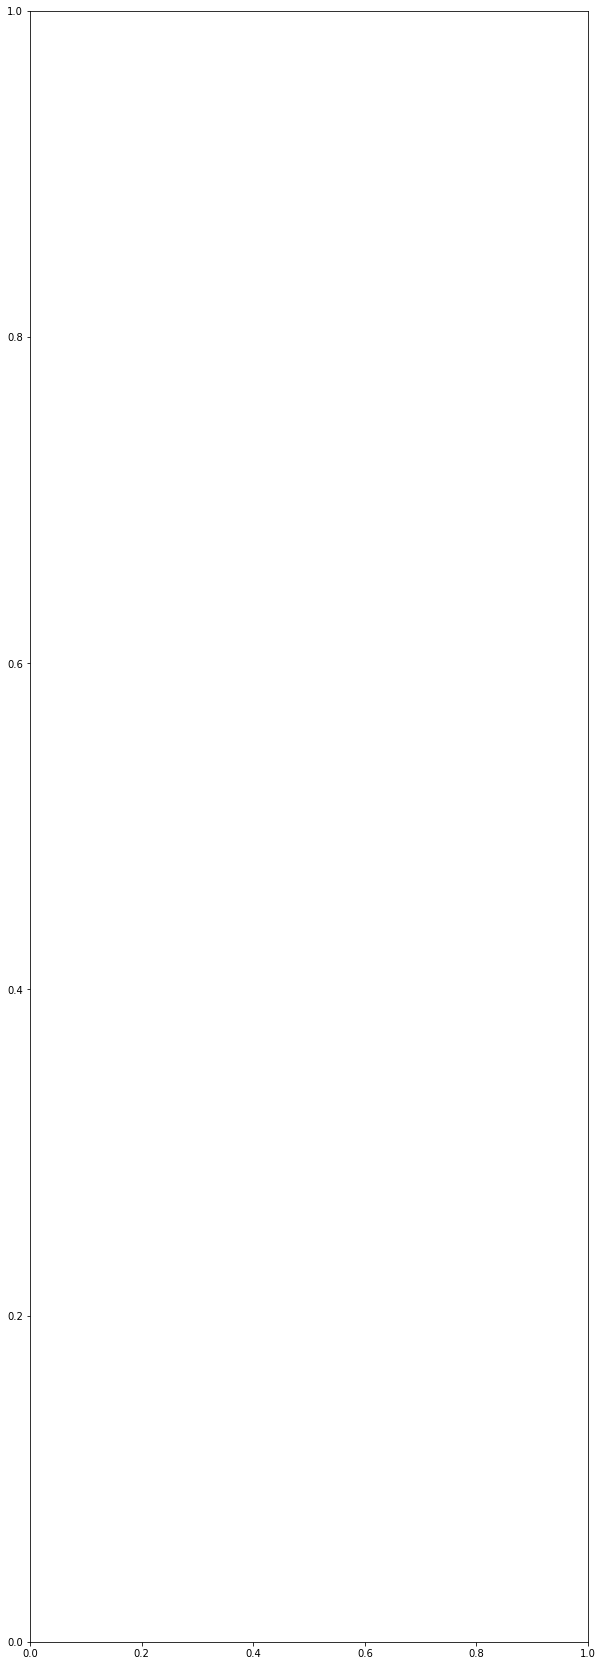

In [9]:
training = False
image_id = 0

CROP_PATH = "/content/drive/My Drive/Computer_Vision/data_notebooks/crop_img_verso_defeito/"

if training:
    train_dataframe = pd.read_csv(os.path.join(PCB_DATASET, "train_data.csv"))

    dataset_train, dataset_val = get_train_data(train_dataframe, 640)

    train_model(dataset_train, dataset_val)
else:

    test_dataframe = pd.read_csv(os.path.join(PCB_DATASET, "test_data.csv"))

    dataset_test = get_test_data(test_dataframe, 640)

    classes = dataset_test.class_names
    # test_image = dataset_test.load_image(image_id)

    test_images = next(os.walk(CROP_PATH))[2]
    test_images = filter(lambda f: f.startswith("placa"), test_images)
    test_images = sorted(test_images)

    for i, test_image in enumerate(test_images):
        test_image = cv2.imread(os.path.join(CROP_PATH, test_image) , cv2.IMREAD_GRAYSCALE)
        if test_image.shape == (640, 640):
            _, test_image = cv2.threshold(test_image, 100, 255, cv2.THRESH_BINARY)
            if len(test_image.shape) < 3: # If image is single channel
                test_image = np.stack((test_image,)*3, axis=-1)

            visualize_predictions(test_image, i, classes, save=True, display=False)